In [2]:
import numpy as np
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector

# Exercise
Trotter evolution is the first order approximation in a class of algorithms called product formulas. Higher orders are simply called product formulas of order $2k$ (they are defined only for even orders as they are symmetric). The second order product formula ($k=1$) for time $t$ and $L$ non-commuting Hamiltonian terms reads
$$
S_1(t) = \prod_{n=1}^L e^{-i H_n t/2} \prod_{n=L}^1 e^{-i H_n t/2} \ .
$$
For $N$ time steps, the time evolution operator is then apprixmated by
$$
U(t) \approx \bigl[ S_1(t/N) \bigr]^N
$$

We have seen how to time evolve an Ising and a Heisenberg Hamiltonian using first order Trotter evolution. In this exercise, we will study the algorithmic error of product formulas in more detail.
We will use a transverse field Ising model to do so.
$$ H = J \sum_i Z_i Z_{i+1} + h \sum_i X_i$$
for $N=4$ sites with $J = 1, h = 0.5$, periodic boundary conditions (PBC).

In [3]:
def get_H_op(N, J, h, pbc):
    """Define the two non-commuting parts of the Hamiltonian separately."""
    
    z_op_strings = []
    for i in range(N - 1):
        z_op_strings.append((N - 2 - i)*"I" + "Z" + "Z" + i*"I")
    # last term for periodic BC
    if pbc and N > 2:
        z_op_strings.append("Z" + (N - 2)*"I" + "Z")
    
    x_op_strings = []
    for i in range(N):
        x_op_strings.append(((N - 1 - i)*"I" + "X" + i*"I"))

    z_ops = SparsePauliOp(data=z_op_strings, coeffs=[J] * (N if (pbc and N > 2) else N - 1))
    x_ops = SparsePauliOp(data=x_op_strings, coeffs=[h] * N)
    
    return z_ops, x_ops

In [4]:
# define basic parameters
N = 4
J = 1
h = 0.5
pbc = True

In [5]:
z_ops, x_ops = get_H_op(N, J, h, pbc)
H_op = z_ops + x_ops
H_mat = H_op.to_matrix()

mag_ave = SparsePauliOp(data=[((N - 1 - i)*"I" + "Z" + i*"I")
                        for i in range(N)], coeffs=[1 / N] * N)
                        
print(f"H_Z =\n{z_ops}")
print(f"H_X =\n{x_ops}")
print(f"H_ising =\n{H_op}")
print(f"M_average =\n{mag_ave}")

mag_ave = mag_ave.to_matrix()

H_Z =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
H_X =
SparsePauliOp(['IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
H_ising =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
M_average =
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


1. Implement both first and second-order product formula using the `PauliEvolutionGate`
    - print the Trotter circuits for two Trotter steps ($t = 1$, $\delta t = 0.5$) in terms of $R_x$ and $R_{zz}$ gates (you can use `QuantumCircuit.decompose().decompose()` to decompose it from the high-level `PauliEvolutionGate` into single- and two-qubit gates).

In [14]:
def trotter_circ(H_op, t, dt, N, init_circ=None, order=1):
    qreg = QuantumRegister(N)
    qc_pauli_gate = QuantumCircuit(qreg)

    Nt = int(t/dt)

    if init_circ is not None:
        qc_pauli_gate.append(init_circ, qreg)

    if order == 1:
        pauli_gate = PauliEvolutionGate(H_op, time=dt)

        for _ in range(Nt):                     
            qc_pauli_gate.append(pauli_gate, qc_pauli_gate.qubits)
            qc_pauli_gate.barrier()

    if order == 2:
        # time steps are halved in this case
        dt = dt / 2
        z_circ = PauliEvolutionGate(H_op[0], time=dt)
        x_circ = PauliEvolutionGate(H_op[1], time=dt)
            
        for _ in range(Nt):                     
            qc_pauli_gate.append(x_circ, qc_pauli_gate.qubits)
            qc_pauli_gate.append(z_circ, qc_pauli_gate.qubits)
            qc_pauli_gate.append(z_circ, qc_pauli_gate.qubits)
            qc_pauli_gate.append(x_circ, qc_pauli_gate.qubits)
            qc_pauli_gate.barrier()


    
    return qc_pauli_gate

In [15]:
gate_1st = trotter_circ(H_op=[z_ops, x_ops], t = 1, dt = 0.5, N = 4, order=1)
gate_1st.decompose().decompose().draw()

┌─────────┐ ░                 »
q22_0: ─■──────────────────────────■──────┤ Rx(0.5) ├─░──■──────────────»
        │ZZ(1)         ┌─────────┐ │      └─────────┘ ░  │ZZ(1)         »
q22_1: ─■───────■──────┤ Rx(0.5) ├─┼──────────────────░──■───────■──────»
                │ZZ(1) └─────────┘ │      ┌─────────┐ ░          │ZZ(1) »
q22_2: ─────────■─────────■────────┼──────┤ Rx(0.5) ├─░──────────■──────»
                          │ZZ(1)   │ZZ(1) ├─────────┤ ░                 »
q22_3: ───────────────────■────────■──────┤ Rx(0.5) ├─░─────────────────»
                                          └─────────┘ ░                 »
«                          ┌─────────┐ ░ 
«q22_0: ────────────■──────┤ Rx(0.5) ├─░─
«       ┌─────────┐ │      └─────────┘ ░ 
«q22_1: ┤ Rx(0.5) ├─┼──────────────────░─
«       └─────────┘ │      ┌─────────┐ ░ 
«q22_2: ───■────────┼──────┤ Rx(0.5) ├─░─
«          │ZZ(1)   │ZZ(1) ├─────────┤ ░ 
«q22_3: ───■────────■──────┤ Rx(0.5) ├─░─
«                          └─────────┘ ░

In [16]:
gate_2nd = trotter_circ(H_op=[z_ops, x_ops], t = 1, dt = 0.5, N = 4, order=2)
gate_2nd.decompose().decompose().draw()


┌──────────┐                                                            »
q23_0: ┤ Rx(0.25) ├─■─────────────────────────────■─────────■──────────────────»
       ├──────────┤ │ZZ(0.5)                      │         │ZZ(0.5)           »
q23_1: ┤ Rx(0.25) ├─■─────────■───────────────────┼─────────■─────────■────────»
       ├──────────┤           │ZZ(0.5)            │                   │ZZ(0.5) »
q23_2: ┤ Rx(0.25) ├───────────■─────────■─────────┼───────────────────■────────»
       ├──────────┤                     │ZZ(0.5)  │ZZ(0.5)                     »
q23_3: ┤ Rx(0.25) ├─────────────────────■─────────■────────────────────────────»
       └──────────┘                                                            »
«                             ┌──────────┐ ░ ┌──────────┐                    »
«q23_0: ─────────────■────────┤ Rx(0.25) ├─░─┤ Rx(0.25) ├─■──────────────────»
«       ┌──────────┐ │        └──────────┘ ░ ├──────────┤ │ZZ(0.5)           »
«q23_1: ┤ Rx(0.25) ├─┼─────────────────────░─┤ Rx(0.25) ├─■─────────■────────»
«       └──────────┘ │        ┌──────────┐ ░ ├──────────┤           │ZZ(0.5) »
«q23_2: ──■──────────┼────────┤ Rx(0.25) ├─░─┤ Rx(0.25) ├───────────■────────»
«         │ZZ(0.5)   │ZZ(0.5) ├──────────┤ ░ ├──────────┤                    »
«q23_3: ──■──────────■────────┤ Rx(0.25) ├─░─┤ Rx(0.25) ├────────────────────»
«                             └──────────┘ ░ └──────────┘                    »
«                                                                     »
«q23_0: ───────────■─────────■───────────────────────────────■────────»
«                  │         │ZZ(0.5)           ┌──────────┐ │        »
«q23_1: ───────────┼─────────■─────────■────────┤ Rx(0.25) ├─┼────────»
«                  │                   │ZZ(0.5) └──────────┘ │        »
«q23_2: ─■─────────┼───────────────────■──────────■──────────┼────────»
«        │ZZ(0.5)  │ZZ(0.5)                       │ZZ(0.5)   │ZZ(0.5) »
«q23_3: ─■─────────■──────────────────────────────■──────────■────────»
«                                                                     »
«       ┌──────────┐ ░ 
«q23_0: ┤ Rx(0.25) ├─░─
«       └──────────┘ ░ 
«q23_1: ─────────────░─
«       ┌──────────┐ ░ 
«q23_2: ┤ Rx(0.25) ├─░─
«       ├──────────┤ ░ 
«q23_3: ┤ Rx(0.25) ├─░─
«       └──────────┘ ░

2. Do the time evolution with both the first and the second order product formula for
    - up to $t = 4$
    - for $N_t \in \{ 5, 10, 20, 50, 100 \}$ time steps.

3. Compute the **infidelity** $1 - |\langle \psi_{\rm exact}(t) | \psi_{\rm trotter}(t) \rangle|^2$ between the exact state at $t = 4$ and the approximate state evolved with the respective product formula.
    - print the final infidelities for each $N_t$ and both for the first and the second order product formula
    - plot the infidelities vs $N_t$ with logarithmic y-scale


In [17]:
def evo_trotter(N, t,  Nt, order = 1):

    qreg = QuantumRegister(N)
    init_circ = QuantumCircuit(qreg)

    dt = t / Nt

    circ = trotter_circ(H_op=[z_ops, x_ops], t = t, dt = dt, N = N, order=order, init_circ=init_circ)
    psi = Statevector(circ).data
    
    return psi


In [18]:
def init_state(N):
    psi_init = np.zeros(1<<N)
    psi_init[0] = 1
    return psi_init

def evo_exact(N, H, t_eval, obs):
    # get initial state
    psi_init = init_state(N)

    psi = expm_multiply(-1j * t_eval * H, psi_init)
        
    return psi

In [19]:
def infidelity(psi_1, psi_2):
    return 1 - abs(np.dot(psi_1, psi_2.conj()))**2

In [20]:
N = 4
t = 4
Nts = [5, 10, 20, 50, 100]

inf_1st = []
inf_2nd = []

res_exact = evo_exact(N, H_mat, 4, mag_ave)

for Nt in Nts:
    dt = t / Nt
    #res_exact = evo_exact(N, H_mat, [4], mag_ave)

    res_trotter_1st = evo_trotter(N, t, Nt, order=1)

    res_trotter_2nd = evo_trotter(N, t, Nt, order=2)

    inf_1st.append(infidelity(res_trotter_1st, res_exact))
    inf_2nd.append(infidelity(res_trotter_2nd, res_exact))



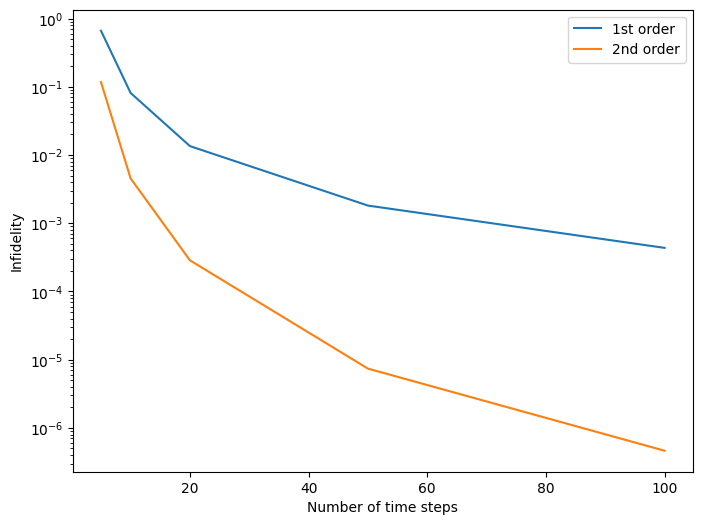

In [21]:
# plot infidelities, log y scale
plt.figure(figsize=(8, 6))
plt.plot(Nts, inf_1st, label="1st order")
plt.plot(Nts, inf_2nd, label="2nd order")
plt.yscale("log")
plt.xlabel("Number of time steps")
plt.ylabel("Infidelity")
plt.legend()
plt.show()